### Dataset Brief
Dataset Ames Housing berisi informasi detail properti real estate di Ames, Iowa dengan 80+ variabel yang mencakup karakteristik fisik bangunan (luas tanah, jumlah kamar, kualitas material), lokasi (zona, lingkungan), fasilitas (garasi, basement, kolam), dan informasi penjualan - dengan target variabel SalePrice untuk prediksi harga jual.

### Use Case Solution

Kami akan mengembangkan model machine learning untuk memprediksi harga jual properti real estate berdasarkan fitur-fitur properti, membantu investor, developer, dan agen properti dalam estimasi harga yang akurat untuk pengambilan keputusan investasi, pricing strategy, dan analisis pasar properti.

In [98]:
# Load libraries
import os
import numpy as np
import pandas as pd
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.gridspec as gridspec

import scipy.stats as stats
from scipy.stats import skew
from datetime import datetime
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import sklearn.linear_model as linear_model
from mlxtend.regressor import StackingCVRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

In [99]:
import matplotlib.style as style
style.use('fivethirtyeight')

In [100]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

### Data Understanding

In [101]:
train = pd.read_csv("./train.csv")

In [102]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [103]:
print(f"Train has {train.shape[0]} rows and {train.shape[1]} columns")

Train has 1460 rows and 81 columns


In [104]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [106]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(train)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageQual,81,5.55
GarageFinish,81,5.55
GarageType,81,5.55


Overview Insight,

Dataset memiliki sekitar 1.400 baris data dengan sekitar 80 fitur di dalamnya, yang terdiri dari berbagai tipe data (int, float, str), disertai pada beberapa kolom memiliki missing value yang masif.

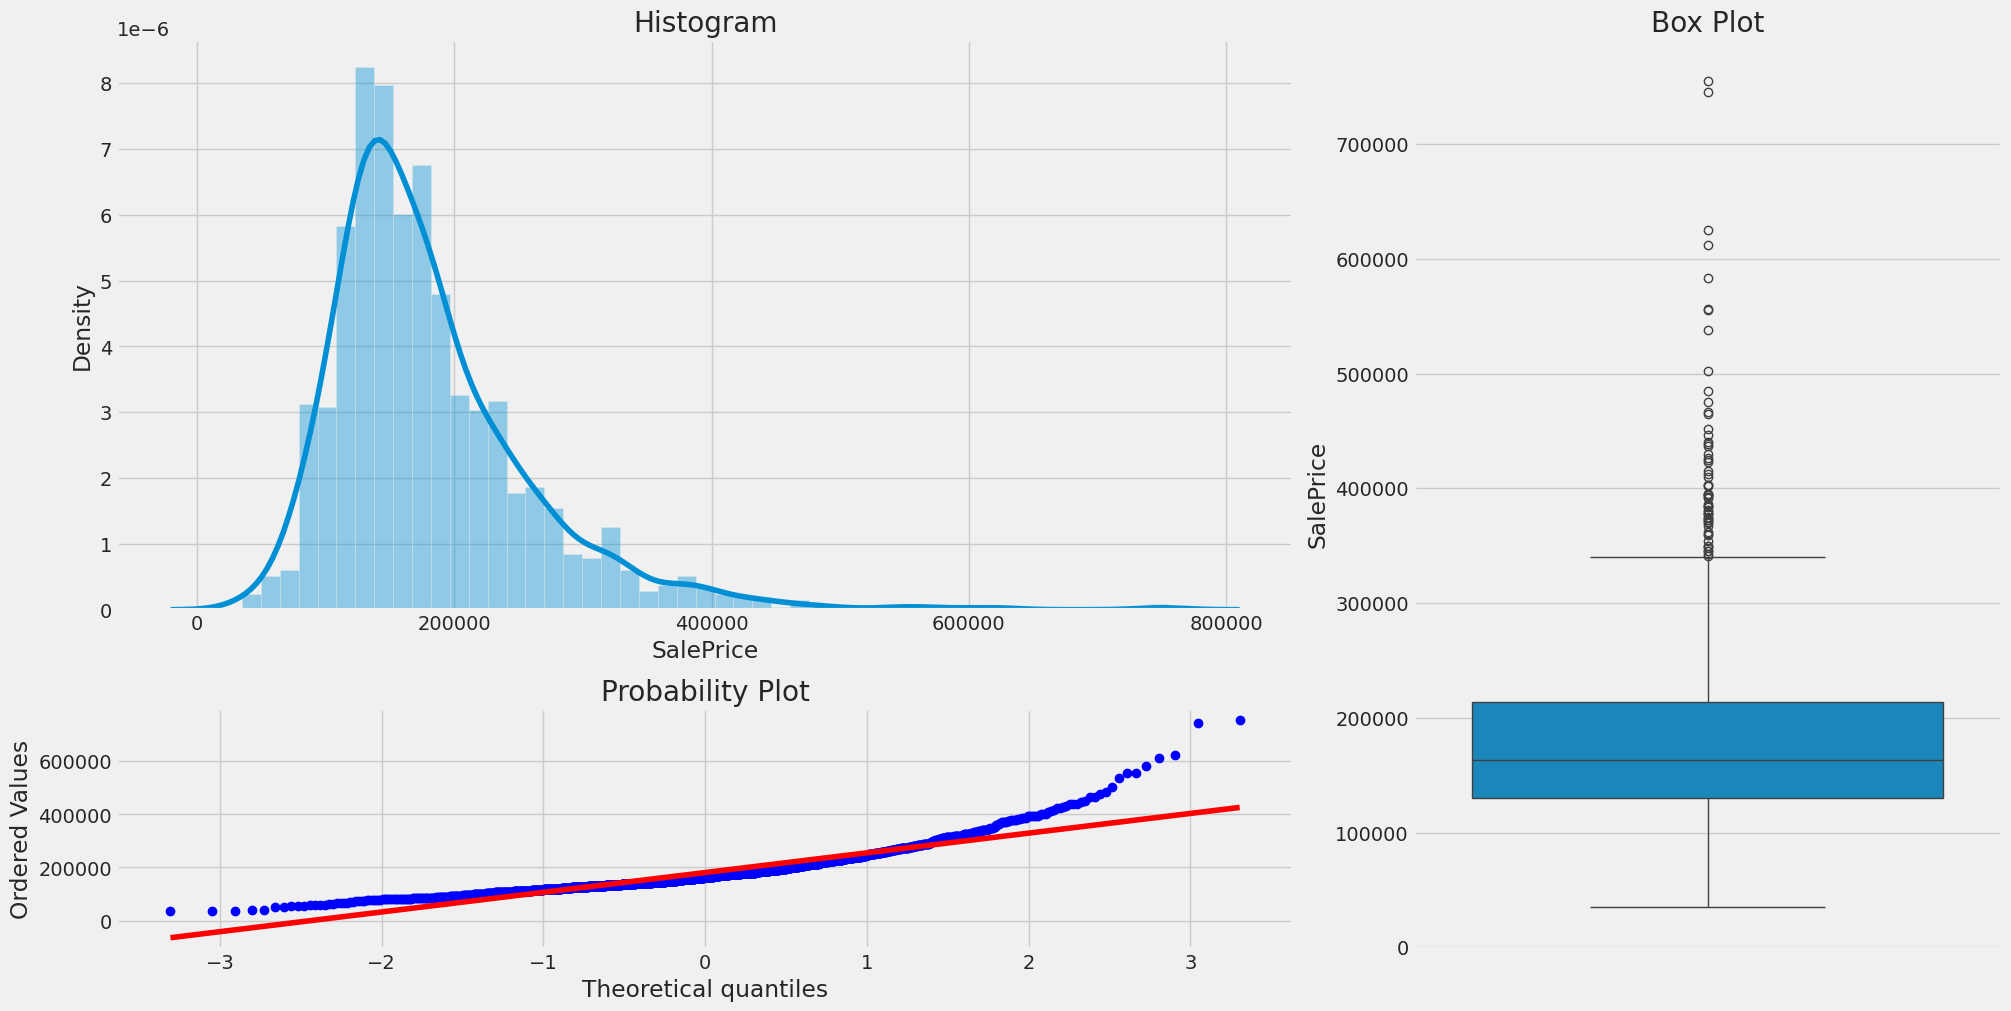

In [107]:
def plotting_3_chart(df, feature):

    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    ax1 = fig.add_subplot(grid[:2, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    ax2 = fig.add_subplot(grid[2, :2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)

    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );

plotting_3_chart(train, 'SalePrice')

In [108]:
print("Skewness: " + str(train['SalePrice'].skew()))
print("Kurtosis: " + str(train['SalePrice'].kurt()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


Glosarium,
- Histogram: Visualisasi distribusi data frekuensi.
- QQ Plot: Membandingkan distribusi data dengan teoretis.
- Box Plot: Ringkasan statistik data visual.
- Kurtosis: Mengukur kepuncakan distribusi data.
- Skewness: Mengukur kemiringan distribusi data.


Insight,

Target variable kita yaitu **SalePrice** distribusinya tidak normal, dimana targetnya cenderung miring ke kanan, serta terdapat indikasi outlier di dalam variable.

### Exploratory Data Analysis

In [109]:
def customized_scatterplot(y, x, title):
    plt.subplots(figsize=(20, 5))
    sns.scatterplot(y=y, x=x)
    plt.title(title);

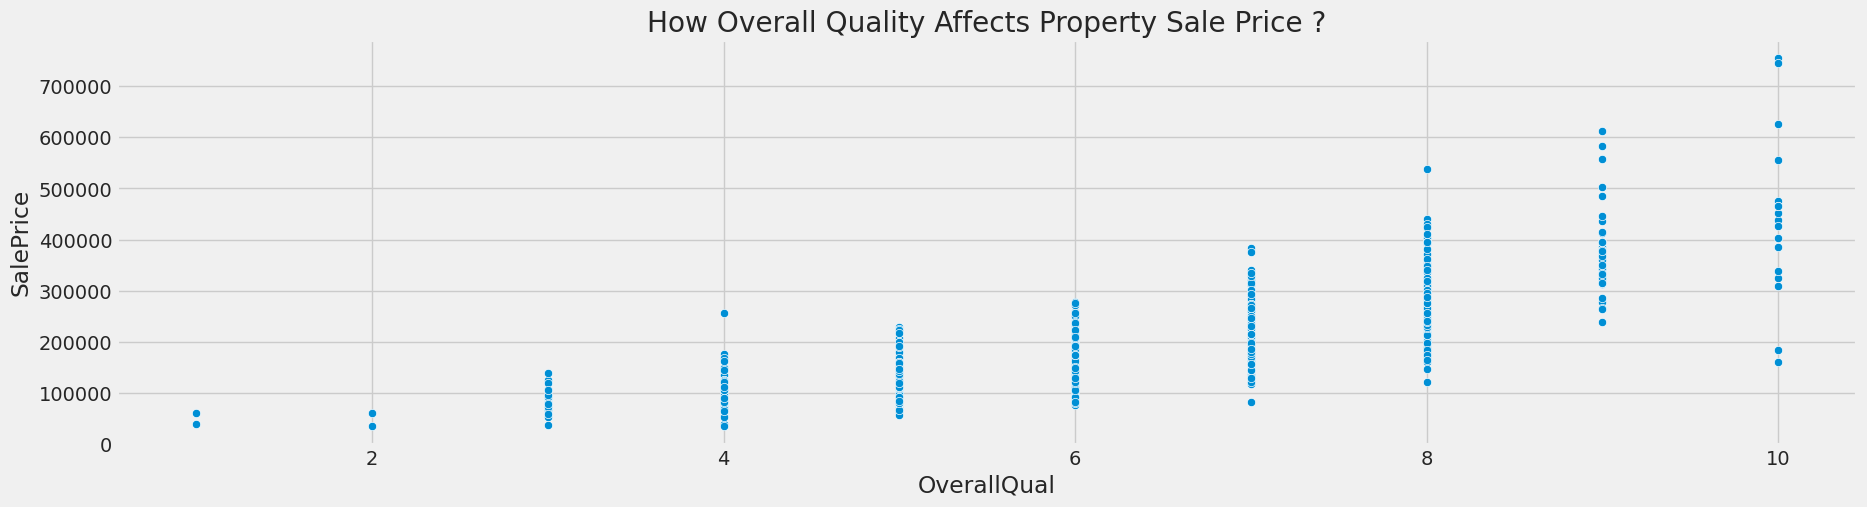

In [110]:
customized_scatterplot(train.SalePrice, train.OverallQual, "How Overall Quality Affects Property Sale Price ?")

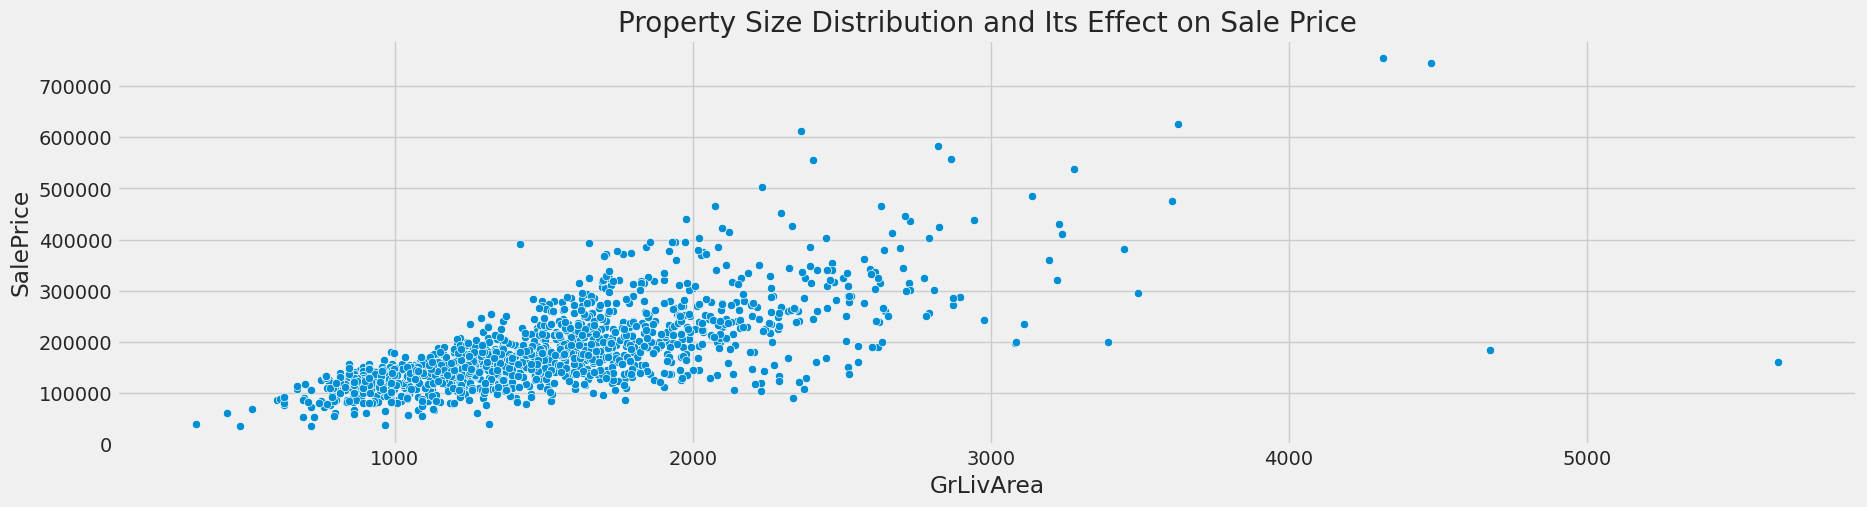

In [111]:
customized_scatterplot(train.SalePrice, train.GrLivArea, "Property Size Distribution and Its Effect on Sale Price")

Observation Result,

Variansi target tidak merata (heteroscedasticity), mengganggu regresi linier; outlier atas kanan pada scatter plot SalePrice vs. GrLivArea mengikuti tren harga naik seiring luas, sedangkan outlier bawah kanan tidak, sehingga akan dihapus.

### Data Wrangling

In [112]:
# Outlier removal
train = train[train.GrLivArea < 4500]
train.reset_index(drop = True, inplace = True)
previous_train = train.copy()

In [113]:
# Normalize target variable with Log Transformation
train["SalePrice"] = np.log1p(train["SalePrice"])

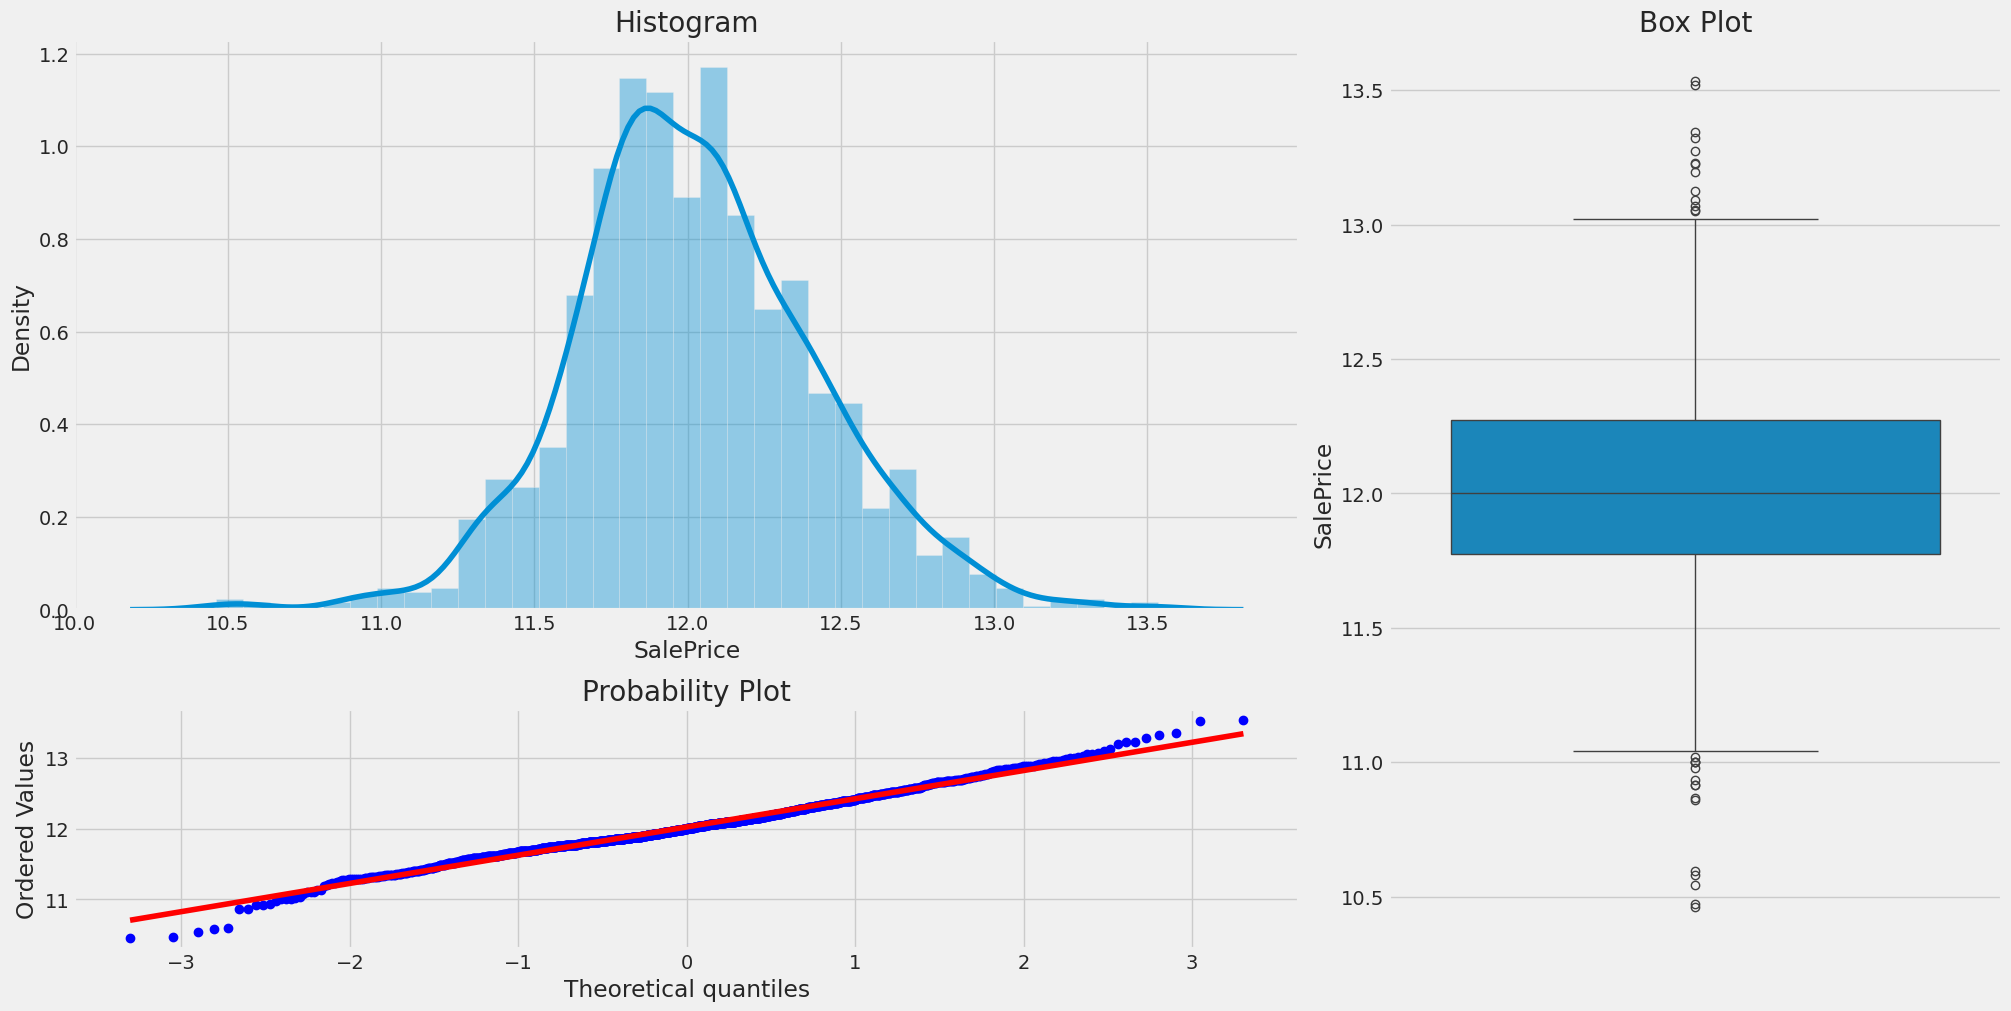

In [114]:
plotting_3_chart(train, 'SalePrice')

### Feature Engineering

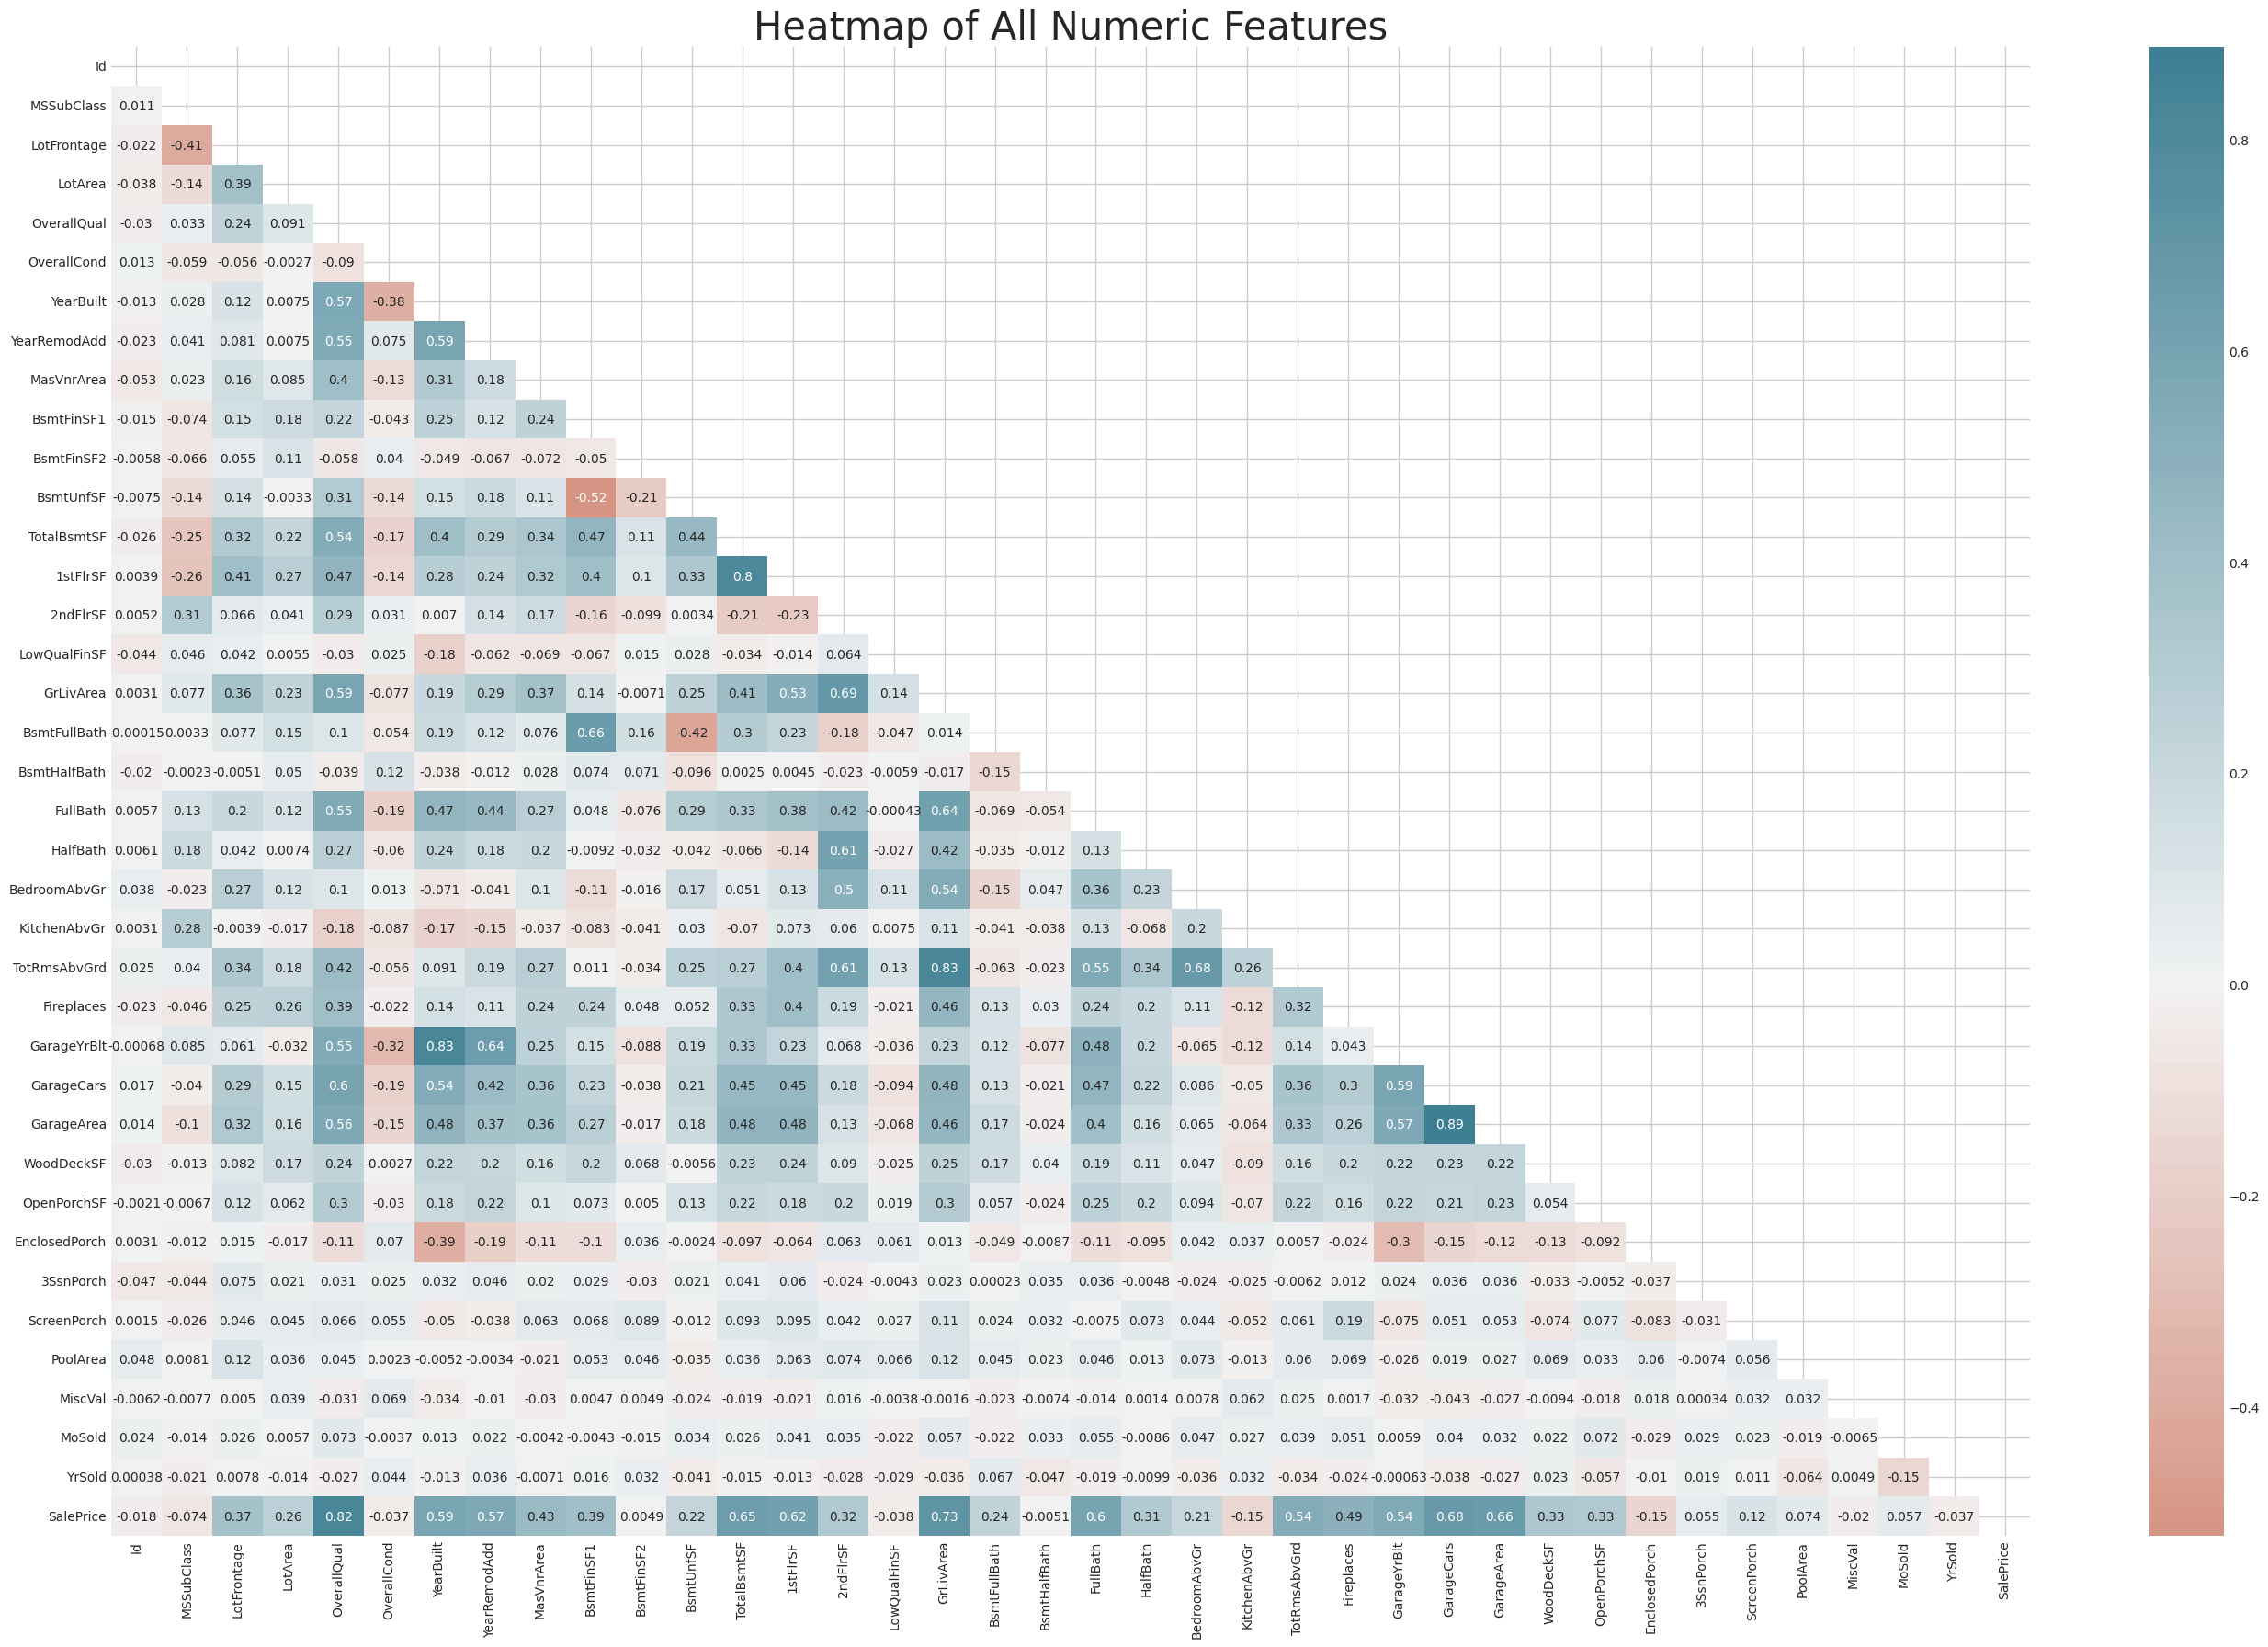

In [115]:
## Plot fig sizing.
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30, 20))

mask = np.zeros_like(train.corr(numeric_only=True), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train.corr(numeric_only=True),
            cmap=sns.diverging_palette(20, 220, n=200),
            mask = mask,
            annot=True,
            center = 0,
           );

plt.title("Heatmap of All Numeric Features", fontsize=30);

Observation Result,

Multikolinearitas masih ada, seperti korelasi 83% antara GarageYrBlt dan YearBuilt, 83% antara TotRmsAbvGrd dan GrLivArea, serta 89% antara GarageCars dan GarageArea; meskipun regresi linier biasanya menghapus fitur ini, kita pertahankan untuk diolah model regularisasi seperti Lasso dan Ridge menggunakan scikit-learn agar hasil optimal.

In [116]:
# Define feature and target
train.drop(columns=['Id'],axis=1, inplace=True)
y = train['SalePrice'].reset_index(drop=True)

previous_train = train.copy()
all_data = train.copy()
all_data.drop(['SalePrice'], axis = 1, inplace = True)

In [117]:
# Missing value treatment - categorical
# NOTE: Beberapa kolom memang memiliki null karena masuk akal, misal 'Alley' / Gang masuk akal kalo beberapa rumah tidak memiliki gang.
missing_val_col = [
    "Alley", "PoolQC", "MiscFeature",
    "Fence", "FireplaceQu", "GarageType",
    "GarageFinish", "GarageQual", "GarageCond",
    'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [118]:
# Missing value treatment - numeric
missing_val_col2 = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
    'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)

In [119]:
# Missing value treatment - median imputation on each neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

In [120]:
# Missing value treatment - mode inputation on SubClass zoning area
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [121]:
# Data casting treatment - dedicated year and month should be categorical (it has specific range)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [122]:
# Missing value treatment - Global Null Handler
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub')
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA")
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr")

In [123]:
# Missing value treatment - mode inputation value
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [124]:
missing_percentage(all_data)

,Total,Percent


ALHAMDULILLAH.

In [125]:
# Overview skew features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_feats

,0
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895
EnclosedPorch,3.083987


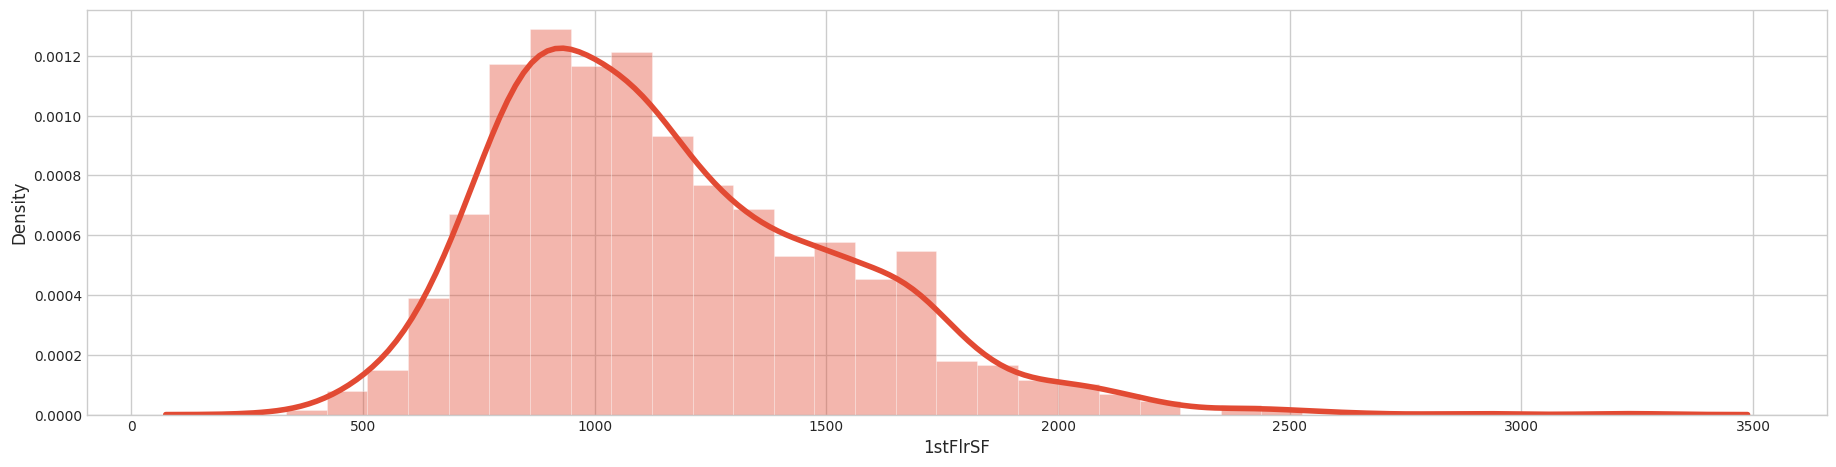

In [126]:
plt.figure(figsize=(20, 5))
sns.distplot(all_data['1stFlrSF']);

In [127]:
def fixing_skewness(df):

    numeric_feats = df.dtypes[df.dtypes != "object"].index
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        try:
            df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))
        except:
            df[feat] = boxcox1p(df[feat], np.log1p(df[feat]))

fixing_skewness(all_data)

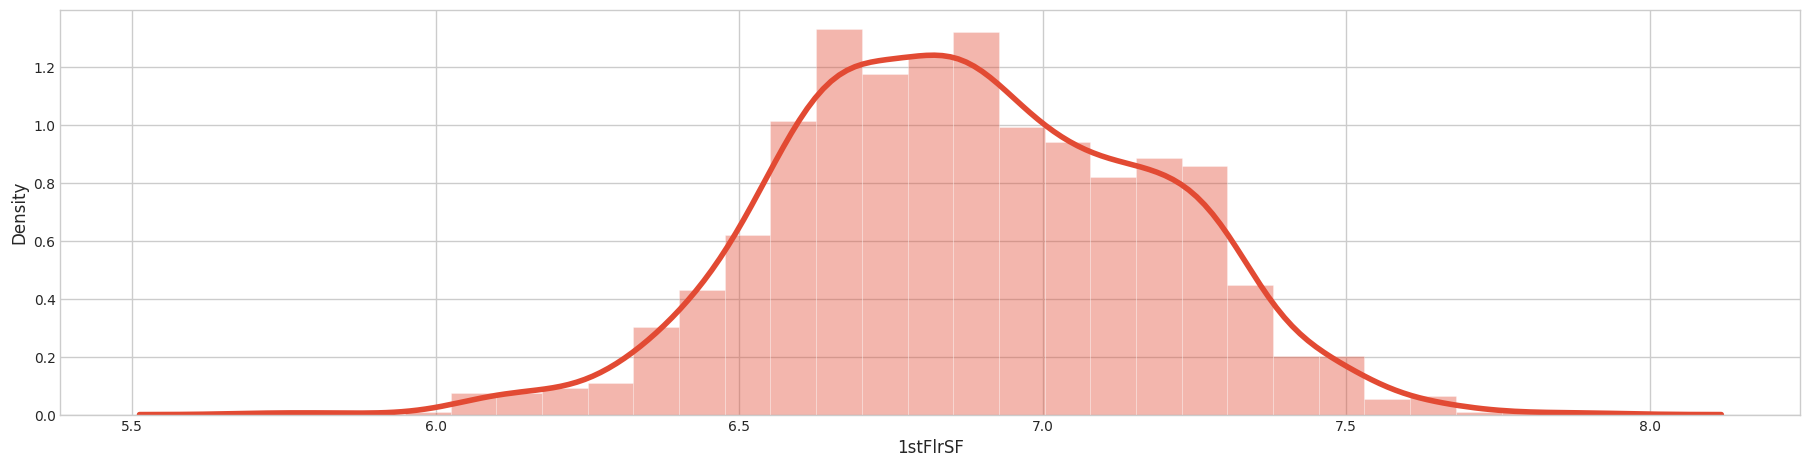

In [128]:
plt.figure(figsize=(20, 5))
sns.distplot(all_data['1stFlrSF']);

In [129]:
# Feature Engineering - create 'total' feature based on separated feature ( basic operation )
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']
all_data['Total_sqr_footage'] = all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['Total_Bathrooms'] = all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath'])
all_data['Total_porch_sf'] = all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF']

# Feature Engineering - boolean condition on certain feature
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# NOTE: On Feature Engineering there were several PoV to do this,
## 1. Domain Knowledge ( Middle to Senior)
## 2. Feature Interaction ( Detail )
## 3. Statistics ( General )

In [ ]:
# Delete unnecessary variable
all_data = all_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

In [130]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,60,RL,14.097978,3.556263e+34,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.040152,4.289786e+52,1.671169e+24,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.445437,Gd,TA,PConc,Gd,TA,No,GLQ,189.923240,Unf,0.0,30.269515,522.159635,GasA,Ex,Y,SBrkr,6.631898,1288.754905,0.0,10.286041,0.994481,0.000000,2,1.070981,3,0.717364,Gd,2.600189,Typ,0.000000,None,Attchd,1.226943e+127,RFn,2,548,TA,TA,Y,0.000000,12.208477,0.000000,0.0,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal,1817.546438,4.289786e+52,1485.310043,3.529971,12.208477,0,1,1,1,0
1,20,RL,15.821431,3.580860e+35,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,4.247351,3.438499e+52,1.362378e+24,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,243.487630,Unf,0.0,44.610473,744.626722,GasA,Ex,Y,SBrkr,7.005440,0.000000,0.0,9.731434,0.000000,0.682666,2,0.000000,3,0.717364,TA,2.257835,Typ,0.925291,TA,Attchd,7.231724e+126,RFn,2,460,TA,TA,Y,61.919812,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.0,5,2007,WD,Normal,751.632161,3.438499e+52,250.493069,2.341333,61.919812,0,0,1,1,1
2,60,RL,14.457327,6.615649e+36,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.040152,4.220502e+52,1.658643e+24,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.779565,Gd,TA,PConc,Gd,TA,Mn,GLQ,142.817019,Unf,0.0,57.566260,557.745767,GasA,Ex,Y,SBrkr,6.701330,1308.151579,0.0,10.366581,0.994481,0.000000,2,1.070981,3,0.717364,Gd,2.257835,Typ,0.925291,TA,Attchd,1.180115e+127,RFn,2,608,TA,TA,Y,0.000000,9.995006,0.000000,0.0,0.0,0.0,None,None,None,0.0,9,2008,WD,Normal,1872.598675,4.220502e+52,1457.669927,3.529971,9.995006,0,1,1,1,1
3,70,RL,13.480261,3.255818e+35,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,3.040152,2.062569e+52,1.301485e+24,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,76.744776,Unf,0.0,65.605789,466.086981,GasA,Gd,Y,SBrkr,6.743304,1131.096315,0.0,10.293595,0.994481,0.000000,1,0.000000,3,0.717364,Gd,2.438140,Typ,0.925291,Gd,Detchd,1.113123e+127,Unf,3,642,TA,TA,Y,0.000000,9.046382,19.056986,0.0,0.0,0.0,None,None,None,0.0,2,2006,WD,Abnorml,1603.926601,2.062569e+52,1214.584395,1.994481,28.103368,0,1,1,1,1
4,60,RL,16.253179,5.687556e+38,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,3.040152,4.186255e+52,1.633855e+24,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.422363,Gd,TA,PConc,Gd,TA,Av,GLQ,179.363983,Unf,0.0,61.904190,681.255539,GasA,Ex,Y,SBrkr,6.911877,1612.742639,0.0,10.755059,0.994481,0.000000,2,1.070981,4,0.717364,Gd,2.747580,Typ,0.925291,TA,Attchd,1.157360e+127,RFn,3,836,TA,TA,Y,46.135921,14.437153,0.000000,0.0,0.0,0.0,None,None,None,0.0,12,2008,WD,Normal,2300.910055,4.186255e+52,1799.018498,3.529971,60.573073,0,1,1,1,1


In [131]:
# Finalize feature extraction - Label Encoder
final_features = pd.get_dummies(all_data).reset_index(drop=True)
X = final_features.iloc[:len(y), :]

In [133]:
final_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Funct

In [132]:
# Remove outlier
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [134]:
def overfit_reducer(df):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = overfit_reducer(X)
X = X.drop(overfitted_features, axis=1)

In [135]:
# Check dimensional
X.shape, y.shape

((1453, 340), (1453,))

### Data Modeling

![](https://lh4.googleusercontent.com/6u1bJFt9SNwVd91igYbODQR8O9p2mD5-9uJkeZTx_zFCDh0558iYSdexm-GX-eTUC2r7kpx1h7u3fzlPWuf2AeKb-EYmHYSyZbzcVxuuwTYd3dQ3FtkjmgQcUZpU_8lhyfrTeqkMpIHWJxiRduW5oZs)

In [136]:
# Define K-Fold and Evaluation Metrics
kfolds = KFold(n_splits=10, shuffle=True, random_state=31)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [137]:
# Define parameter tuning variance
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [152]:
# Define regression model with certain parameter
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1000, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1000, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [160]:
# Training model on cross-val scoring
import time
metrics_result = {}
training_candidates = {
    "Ridge": ridge,
    "Lasso": lasso,
    "Elastic Net": elasticnet,
    "Support Vector Regression": svr
}

for model_name, model_obj in training_candidates.items():
    start_time = time.time()
    score_evaluation = cv_rmse(model_obj)
    end_time = time.time() - start_time
    metrics_result[model_name] = [end_time, score_evaluation.mean(), score_evaluation.std()]
    metrics_result[model_name].extend(score_evaluation)

In [165]:
metrics_eval = pd.DataFrame(metrics_result)
metrics_eval_transpose = metrics_eval.T
metrics_eval_transpose.columns = ["Execution Time", "Avg. RMSE Score", "Std. RMSE Score"] + [f"Fold - {n+1}" for n in range(10)]
metrics_eval_transpose

,Execution Time,Avg. RMSE Score,Std. RMSE Score,Fold - 1,Fold - 2,Fold - 3,Fold - 4,Fold - 5,Fold - 6,Fold - 7,Fold - 8,Fold - 9,Fold - 10
Ridge,68.199116,0.612196,1.524180,0.106618,0.095864,0.099434,0.095413,0.138346,0.103694,5.184566,0.086608,0.100353,0.111066
Lasso,39.951069,0.500086,1.190009,0.109720,0.094804,0.096878,0.103806,0.133554,0.100780,4.069929,0.084410,0.100621,0.106355
Elastic Net,191.572670,0.497948,1.184466,0.109720,0.094986,0.096844,0.100574,0.133619,0.101067,4.051162,0.084412,0.100612,0.106479
Support Vector Regression,6.355119,0.158766,0.029373,0.161670,0.133968,0.107954,0.177057,0.194204,0.197412,0.169850,0.149775,0.117080,0.178694
